**Import libraries**

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb
color = sns.cubehelix_palette(10, start=2, rot=0, dark=0.2, light=0.8, reverse=True)
%matplotlib inline

# Training models#

## Read data##

In [3]:
aisles = pd.read_csv('aisles.csv')
depts = pd.read_csv('departments.csv')
orders = pd.read_csv('orders.csv')
products = pd.read_csv('products.csv')
prior = pd.read_csv('order_products__prior.csv')
train = pd.read_csv('order_products__train.csv')

## Data cleaning##

There is no NAN value in any table except the column orders['days_since_prior_order']  
And the NAN value in orders['days_since_prior_order'] means the order is the first order for that user so it doesn't have prior order.  
So there is no need for us to remove any row with NAN value.

In [4]:
orders.head()

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,2539329,1,prior,1,2,8,NaN
1,2398795,1,prior,2,3,7,15.0
2,473747,1,prior,3,3,12,21.0
3,2254736,1,prior,4,4,7,29.0
4,431534,1,prior,5,4,15,28.0


Also, products['product_name'], aisles['aisle'], departments['department'] has string data.  
In case there are any mis-spellings, I lowercase all the strings and remove the space at the end of the string

In [5]:
products['product_name']=products['product_name'].str.lower().str.strip() 
aisles['aisle']=aisles['aisle'].str.lower().str.strip() 
depts['department']=depts['department'].str.lower().str.strip()

In [6]:
products.head()

,product_id,product_name,aisle_id,department_id
0,1,chocolate sandwich cookies,61,19
1,2,all-seasons salt,104,13
2,3,robust golden unsweetened oolong tea,94,7
3,4,smart ones classic favorites mini rigatoni wit...,38,1
4,5,green chile anytime sauce,5,13


In [7]:
aisles.head()

,aisle_id,aisle
0,1,prepared soups salads
1,2,specialty cheeses
2,3,energy granola bars
3,4,instant foods
4,5,marinades meat preparation


In [8]:
depts.head()

,department_id,department
0,1,frozen
1,2,other
2,3,bakery
3,4,produce
4,5,alcohol


## Merge prior table with order table##

In [9]:
orders.set_index('order_id', inplace=True, drop=False)
prior = prior.join(orders, on='order_id', rsuffix='_')
prior.drop('order_id_', inplace=True, axis=1)
prior.head()

,order_id,product_id,add_to_cart_order,reordered,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,2,33120,1,1,202279,prior,3,5,9,8.0
1,2,28985,2,1,202279,prior,3,5,9,8.0
2,2,9327,3,0,202279,prior,3,5,9,8.0
3,2,45918,4,1,202279,prior,3,5,9,8.0
4,2,30035,5,0,202279,prior,3,5,9,8.0


# LightGBM#

**Preprosessing**

We add three new columns to the product dataframe that are orders, reorders and reorder_rate, by grouping together the product_id in prior dataframe.

In [10]:
print("Computing Product f")
prods = pd.DataFrame()
# order nums of the product
prods['orders'] = prior.groupby(prior.product_id).size().astype(np.int32)
# reorder times
prods['reorders'] = prior['reordered'].groupby(prior.product_id).sum().astype(np.int32)
# reorder rate
prods['reorder_rate'] = (prods.reorders/prods.orders).astype(np.float32)

# join products with prods
products = products.join(prods, on='product_id')
products.set_index('product_id', drop=False, inplace=True)
products.head()
del prods

Computing Product f


**User Feature**

In [11]:
print("Computing User Features")
usr = pd.DataFrame()
usr['average_days_between_orders'] = orders.groupby('user_id')['days_since_prior_order'].mean().astype(np.float32)
# order numbers
usr['nb_orders'] = orders.groupby('user_id').size().astype(np.int16)
usr.head()

Computing User Features


,average_days_between_orders,nb_orders
user_id,,
1,19.000000,11
2,16.285715,15
3,12.000000,13
4,17.000000,6
5,11.500000,5


In [12]:
# Creating features from the customer buying patterns
users = pd.DataFrame()
users['total_items'] = prior.groupby('user_id').size().astype(np.int16)
users['all_products'] = prior.groupby('user_id')['product_id'].apply(set)
users['total_distinct_items'] = users.all_products.map(len).astype(np.int16)

In [13]:
users = users.join(usr)
del usr

In [14]:
# total_items is the total number of products that were bought by a particular user.
users['average_basket'] = users.total_items/users.nb_orders
users.head()
# The average_basket gives us the average number of product a particular user's basket have.

,total_items,all_products,total_distinct_items,average_days_between_orders,nb_orders,average_basket
user_id,,,,,,
1,59,"{17122, 196, 26405, 46149, 14084, 13032, 26088...",18,19.000000,11,5.363636
2,195,"{45066, 2573, 18961, 23, 32792, 1559, 22559, 1...",102,16.285715,15,13.000000
3,88,"{17668, 44683, 48523, 21903, 14992, 21137, 324...",33,12.000000,13,6.769231
4,18,"{21573, 42329, 17769, 35469, 37646, 1200, 1905...",17,17.000000,6,3.000000
5,37,"{11777, 40706, 28289, 48775, 20754, 6808, 1398...",23,11.500000,5,7.400000


**userXproduct features**

In [15]:
prior['user_product'] = prior.product_id + prior.user_id * 100000

In [16]:
prior.head()

,order_id,product_id,add_to_cart_order,reordered,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,user_product
0,2,33120,1,1,202279,prior,3,5,9,8.0,20227933120
1,2,28985,2,1,202279,prior,3,5,9,8.0,20227928985
2,2,9327,3,0,202279,prior,3,5,9,8.0,20227909327
3,2,45918,4,1,202279,prior,3,5,9,8.0,20227945918
4,2,30035,5,0,202279,prior,3,5,9,8.0,20227930035


In [17]:
# We make a new DataFrame for each unique combination of user and product
# We add the number of times that particular product was ordered by the user
# it's added to cart order and the last ordered item

d = dict()
for row in prior.itertuples():
    z = row.user_product
    if z not in d:
        d[z] = (1, (row.order_number, row.order_id),row.add_to_cart_order)
    else:
        d[z] = (d[z][0] + 1, max(d[z][1], (row.order_number, row.order_id)), d[z][2] + row.add_to_cart_order)

In [18]:
# Converting to DataFrame
userXproduct = pd.DataFrame.from_dict(d, orient='index')
del d

In [19]:
userXproduct.columns = ['nb_orders', 'last_order_id', 'sum_pos_in_cart']
userXproduct.nb_orders = userXproduct.nb_orders.astype(np.int16)
# Only take the id of the last ordered item.
userXproduct.last_order_id = userXproduct.last_order_id.map(lambda x: x[1]).astype(np.int32)
userXproduct.sum_pos_in_cart = userXproduct.sum_pos_in_cart.astype(np.int16)
print('user X product f', len(userXproduct))
del prior

user X product f 13307953


In [20]:
userXproduct.head()

,nb_orders,last_order_id,sum_pos_in_cart
20227933120,5,104690,10
20227928985,5,132412,16
20227909327,1,2,3
20227945918,5,2382766,24
20227930035,3,2382766,14


**Split orders into train and test**

In [21]:
### train / test orders ###
print('split orders : train, test')
test_orders = orders[orders.eval_set == 'test']
train_orders = orders[orders.eval_set == 'train']

train.set_index(['order_id', 'product_id'], inplace=True, drop=False)

split orders : train, test


In [22]:
train_orders.head()

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
order_id,,,,,,,
1187899,1187899,1,train,11,4,8,14.0
1492625,1492625,2,train,15,1,11,30.0
2196797,2196797,5,train,5,0,11,6.0
525192,525192,7,train,21,2,11,6.0
880375,880375,8,train,4,1,14,10.0


In [23]:
# return dataframe and labels
def features(selected_orders, labels_given=False):
    print('build candidate list')
    order_list = []
    product_list = []
    labels = []
    i=0
    for row in selected_orders.itertuples():
        i+=1
        if i%10000 == 0: print('order row',i)
        order_id = row.order_id
        user_id = row.user_id
        user_products = users.all_products[user_id]
        product_list += user_products
        # A list with order_id repeated len(user_products) time.
        order_list += [order_id] * len(user_products)
        if labels_given:
            labels += [(order_id, product) in train.index for product in user_products]
        
    df = pd.DataFrame({'order_id':order_list, 'product_id':product_list}, dtype=np.int32)
    labels = np.array(labels, dtype=np.int8)
    del order_list
    del product_list
    
    print('user related features')
    df['user_id'] = df.order_id.map(orders.user_id)
    df['user_total_orders'] = df.user_id.map(users.nb_orders)
    df['user_total_items'] = df.user_id.map(users.total_items)
    df['total_distinct_items'] = df.user_id.map(users.total_distinct_items)
    df['user_average_days_between_orders'] = df.user_id.map(users.average_days_between_orders)
    df['user_average_basket'] =  df.user_id.map(users.average_basket)
    
    print('order related features')
    # df['dow'] = df.order_id.map(orders.order_dow)
    df['order_hour_of_day'] = df.order_id.map(orders.order_hour_of_day)
    df['days_since_prior_order'] = df.order_id.map(orders.days_since_prior_order)
    df['days_since_ratio'] = df.days_since_prior_order / df.user_average_days_between_orders
    
    print('product related features')
    df['aisle_id'] = df.product_id.map(products.aisle_id)
    df['department_id'] = df.product_id.map(products.department_id)
    df['product_orders'] = df.product_id.map(products.orders).astype(np.int32)
    df['product_reorders'] = df.product_id.map(products.reorders)
    df['product_reorder_rate'] = df.product_id.map(products.reorder_rate)

    print('user_X_product related features')
    df['z'] = df.user_id * 100000 + df.product_id
    df.drop(['user_id'], axis=1, inplace=True)
    df['UP_orders'] = df.z.map(userXproduct.nb_orders)
    df['UP_orders_ratio'] = (df.UP_orders / df.user_total_orders).astype(np.float32)
    df['UP_last_order_id'] = df.z.map(userXproduct.last_order_id)
    df['UP_average_pos_in_cart'] = (df.z.map(userXproduct.sum_pos_in_cart) / df.UP_orders).astype(np.float32)
    df['UP_reorder_rate'] = (df.UP_orders / df.user_total_orders).astype(np.float32)
    df['UP_orders_since_last'] = df.user_total_orders - df.UP_last_order_id.map(orders.order_number)
    df['UP_delta_hour_vs_last'] = abs(df.order_hour_of_day - df.UP_last_order_id.map(orders.order_hour_of_day)).map(lambda x: min(x, 24-x)).astype(np.int8)
    #df['UP_same_dow_as_last_order'] = df.UP_last_order_id.map(orders.order_dow) == \
    #                                              df.order_id.map(orders.order_dow)

    df.drop(['UP_last_order_id', 'z'], axis=1, inplace=True)
    print(df.dtypes)
    print(df.memory_usage())
    return (df, labels)

In [24]:
df_train, labels = features(train_orders, labels_given=True)

build candidate list
order row 10000
order row 20000
order row 30000
order row 40000
order row 50000
order row 60000
order row 70000
order row 80000
order row 90000
order row 100000
order row 110000
order row 120000
order row 130000
user related features
order related features
product related features
user_X_product related features
order_id                              int32
product_id                            int32
user_total_orders                     int16
user_total_items                      int16
total_distinct_items                  int16
user_average_days_between_orders    float32
user_average_basket                 float64
order_hour_of_day                     int64
days_since_prior_order              float64
days_since_ratio                    float64
aisle_id                              int64
department_id                         int64
product_orders                        int32
product_reorders                    float64
product_reorder_rate                float32
UP_or

In [25]:
f_to_use = ['user_total_orders', 'user_total_items', 'total_distinct_items',
       'user_average_days_between_orders', 'user_average_basket',
       'order_hour_of_day', 'days_since_prior_order', 'days_since_ratio',
       'aisle_id', 'department_id', 'product_orders', 'product_reorders',
       'product_reorder_rate', 'UP_orders', 'UP_orders_ratio',
       'UP_average_pos_in_cart', 'UP_reorder_rate', 'UP_orders_since_last',
       'UP_delta_hour_vs_last'] # 'dow', 'UP_same_dow_as_last_order'

## Train the LGB model##

In [26]:
d_train = lgb.Dataset(df_train[f_to_use], 
                     label=labels,
                     categorical_feature=['aisle_id', 'department_id'])  # , 'order_hour_of_day', 'dow'
del df_train

In [27]:
d_train

In [28]:
params = {
    'task': 'train',
    'boosting_type': 'gbdt',
    'objective': 'binary',
    'metric': {'binary_logloss'},
    'num_leaves': 96,
    'max_depth': 10,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.95,
    'bagging_freq': 5
}
ROUNDS = 100

print('light GBM train :-)')
bst = lgb.train(params, d_train, ROUNDS)
# lgb.plot_importance(bst, figsize=(9,20))
del d_train

light GBM train :-)


D:\Software_2\Anaconda\lib\site-packages\lightgbm\basic.py:1243: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


In [29]:
### build candidates list for test ###

df_test, _ = features(test_orders)

print('light GBM predict')
preds = bst.predict(df_test[f_to_use])

df_test['pred'] = preds

TRESHOLD = 0.22  # guess, should be tuned with crossval on a subset of train data

d = dict()
for row in df_test.itertuples():
    if row.pred > TRESHOLD:
        try:
            d[row.order_id] += ' ' + str(row.product_id)
        except:
            d[row.order_id] = str(row.product_id)

for order in test_orders.order_id:
    if order not in d:
        d[order] = 'None'

sub = pd.DataFrame.from_dict(d, orient='index')

build candidate list
order row 10000
order row 20000
order row 30000
order row 40000
order row 50000
order row 60000
order row 70000
user related features
order related features
product related features
user_X_product related features
order_id                              int32
product_id                            int32
user_total_orders                     int16
user_total_items                      int16
total_distinct_items                  int16
user_average_days_between_orders    float32
user_average_basket                 float64
order_hour_of_day                     int64
days_since_prior_order              float64
days_since_ratio                    float64
aisle_id                              int64
department_id                         int64
product_orders                        int32
product_reorders                    float64
product_reorder_rate                float32
UP_orders                             int16
UP_orders_ratio                     float32
UP_average_pos_in

In [30]:
sub.reset_index(inplace=True)
sub.columns = ['order_id', 'products']
sub.to_csv('sub.csv', index=False)

In [31]:
sub

,order_id,products
0,2774568,17668 21903 39190 47766 18599 43961 23650 24810
1,1528013,21903 38293
2,1376945,33572 28465 27959 44632 24799 34658 14947 8309...
3,1356845,11520 14992 7076 28134 10863 21616 13176
4,2161313,11266 196 10441 12427 37710 48142 14715 27839
5,1416320,5134 21903 21137 24852 17948 41950 21616 24561
6,1735923,17008 2192 196 15599 31487 15131 35123 12108 3...
7,1980631,13575 6184 9387 46061 13914 41400 22362
8,139655,27845
9,1411408,26452 22008


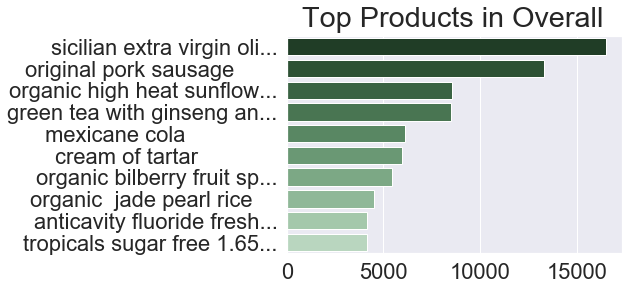

In [50]:
def get_value_count_and_plot(data, title, limit=10):
    prod_ids = []
    for row in data.products:
        if row != "None":
            for prod_id in row.split():   
                prod_ids += [prod_id]

    prod_ids = pd.Series(prod_ids, dtype = np.int32)
    value_count = prod_ids.value_counts()[:limit]
    prod_ids = value_count.index.values;
    prod_names = products[products.product_id.isin(value_count)].product_name
    prod_names = [name[:25]+'...' if len(name)>25 else "{0:<28}".format(name) for name in prod_names] # truncate names for presentation
    
    sns.set(font_scale=2)
    sns.barplot(y=prod_names, x=value_count.values, orient='h', palette=color)
    plt.suptitle(title)
    plt.show()
    
title =" Top Products in Overall"
get_value_count_and_plot(sub, title)